In [1]:
!nvidia-smi

Thu Apr 28 01:19:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Imports

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import seaborn as sns
import re
import os
import copy
from tqdm.notebook import tqdm
import gc

Perform exploratory data analysis (EDA)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.chdir('/content/drive/My Drive/Research/Arxiv')

In [ ]:
arxiv_data = []
with open('/content/drive/My Drive/Research/Arxiv/arxiv-metadata.json', 'r') as f:
  for line in f:
    arxiv_data.append(json.loads(line))
  arxiv_data = pd.DataFrame(arxiv_data)
  
keep_cols = ['id', 'title', 'abstract', 'categories']
arxiv_data = arxiv_data[keep_cols]

In [ ]:
arxiv_data.shape

(1773372, 181)

In [ ]:
arxiv_data.head(2)

,id,title,abstract,categories
0,0704.0001,Calculation of prompt diphoton production cros...,A fully differential calculation in perturba...,hep-ph
1,0704.0002,Sparsity-certifying Graph Decompositions,"We describe a new algorithm, the $(k,\ell)$-...",math.CO cs.CG


In [ ]:
# save unprocessed arxiv data set as csv
arxiv_data.to_csv('full_arxiv_data.csv', index = False)

In [ ]:
arxiv_data = pd.read_csv('/content/drive/My Drive/Research/Arxiv/full_arxiv_data.csv')
arxiv_data.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1774609, 4)

In [ ]:
# create columns for each uniqe title
unique_categories = set([i for l in [x.split(' ') for x in arxiv_data['categories']] for i in l])
print(f"There are {len(unique_categories)} unique categories in dataset.")

for un in unique_categories:
  arxiv_data[un] = np.where(arxiv_data['categories'].str.contains(un), 1, 0)

There are 176 unique categories in dataset.


In [ ]:
arxiv_data.shape

(1774609, 180)

In [ ]:
# remove withdrawn records
arxiv_data = arxiv_data[arxiv_data['abstract'].str.contains('paper has been withdrawn') == False]

In [ ]:
arxiv_data.shape

(1773372, 180)

In [ ]:
arxiv_data.head(2)

,id,title,abstract,categories,nucl-ex,cs.LG,econ.EM,astro-ph,physics.atm-clus,math.HO,cond-mat.supr-con,q-bio.OT,q-bio.SC,q-fin.GN,q-bio.NC,nlin.SI,stat.AP,hep-ex,cs.IR,astro-ph.HE,cond-mat.stat-mech,astro-ph.GA,adap-org,cond-mat.mtrl-sci,q-bio.CB,math.PR,q-bio.BM,quant-ph,math.SG,cond-mat.other,q-fin.MF,hep-th,cs.AI,patt-sol,cs.IT,q-bio.TO,stat.OT,cs.CE,cond-mat.dis-nn,math.DG,...,math.QA,cs.SY,cs.DS,q-bio.QM,chao-dyn,q-fin.CP,gr-qc,physics.flu-dyn,cs.OS,alg-geom,cs.CC,cs.SC,econ.GN,astro-ph.EP,math-ph,cs.DM,physics.comp-ph,math.AC,nlin.PS,cs.MA,cs.MM,math.CV,math.GR,nlin.CG,chem-ph,math.AG,nlin.CD,cs.OH,math.RA,q-fin.PM,funct-an,physics.class-ph,cs.AR,math.ST,cs.PL,math.GM,cs.DL,math.DS,cond-mat.mes-hall,math.AP
0,704,Calculation of prompt diphoton production cros...,A fully differential calculation in perturba...,hep-ph,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,704,Sparsity-certifying Graph Decompositions,"We describe a new algorithm, the $(k,\ell)$-...",math.CO cs.CG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# save cleaned(not withdrawn, not duplicate) arxiv data set as csv
arxiv_data.to_csv('labeled_full_arxiv_data.csv', index = False)

Generate counts by labeled category to determine exclusions

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


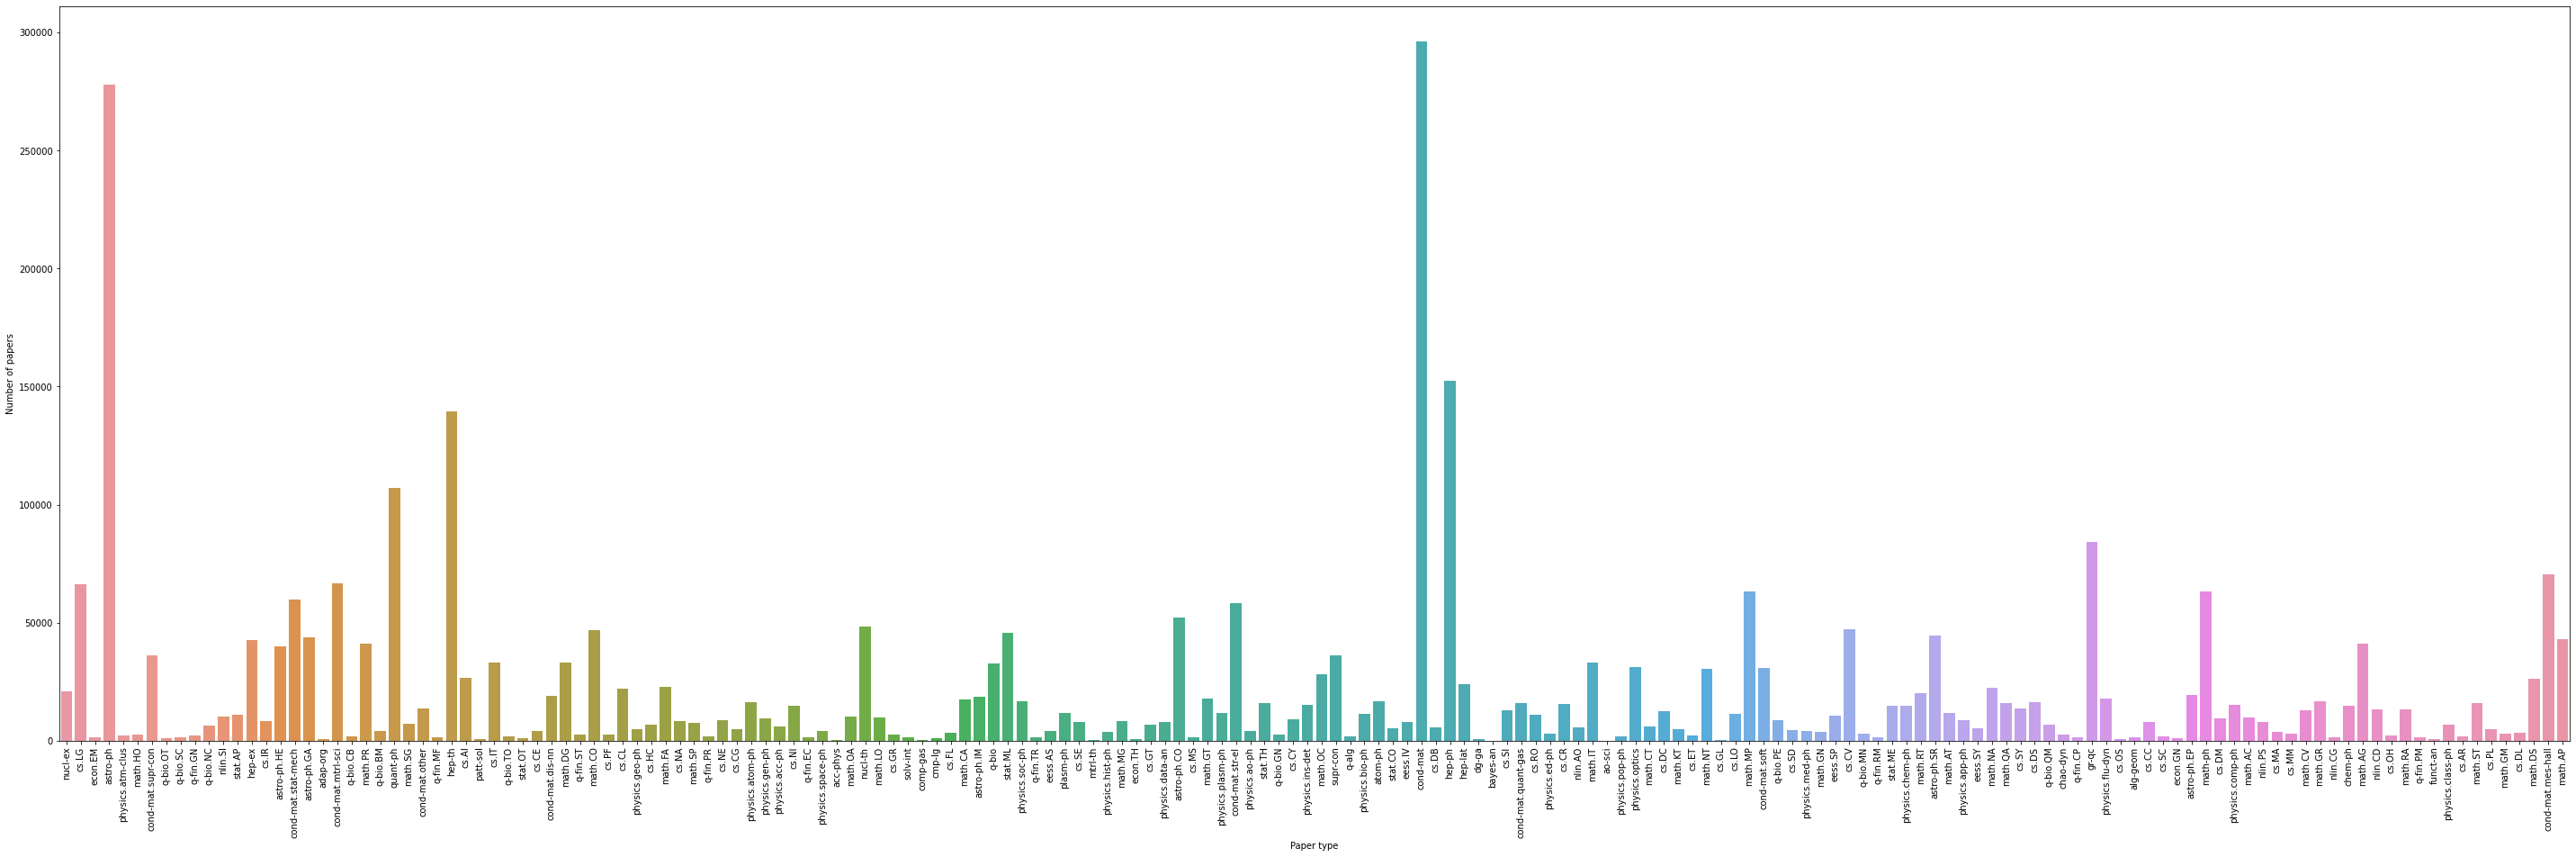

In [ ]:
# no. of samples for each class
categories = arxiv_data.columns.to_list()[4:]
plt.figure(figsize=(50, 15))

ax = sns.barplot(categories, arxiv_data.iloc[:, 4:].sum().values)
plt.ylabel('Number of papers')
plt.xlabel('Paper type')
plt.xticks(rotation=90)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


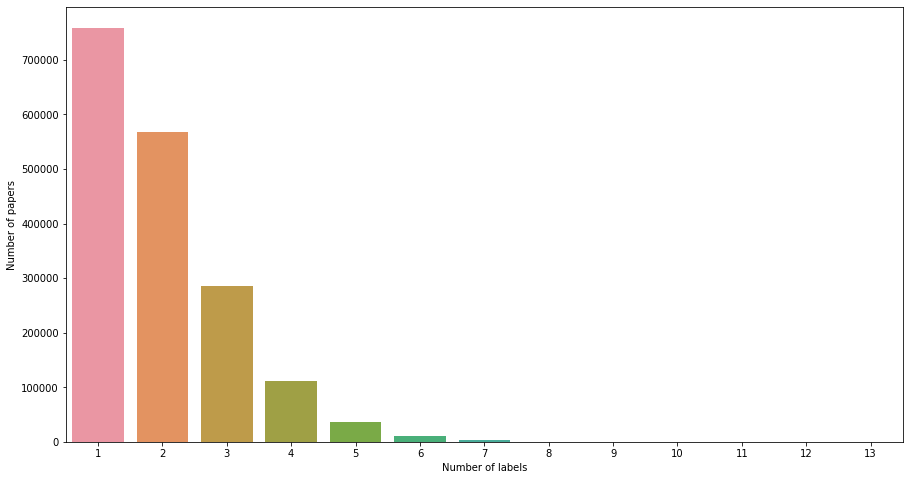

In [ ]:
# no of samples having multiple labels
row_sums = arxiv_data.iloc[:, 4:].sum(axis=1)
multilabel_counts = row_sums.value_counts()

plt.figure(figsize=(15, 8))
ax = sns.barplot(multilabel_counts.index, multilabel_counts.values)
plt.ylabel('Number of papers')
plt.xlabel('Number of labels')
plt.show()

In [ ]:
# preprocessing
def clean_text(text):
    text = text.split()
    text = [x.strip() for x in text]
    text = [x.replace('\n', ' ').replace('\t', ' ') for x in text]
    text = ' '.join(text)
    text = re.sub('([.,!?()])', r' \1 ', text)
    return text

def get_texts(df):
    titles = df['title'].apply(clean_text)
    titles = titles.values.tolist()
    abstracts = df['abstract'].apply(clean_text)
    abstracts = abstracts.values.tolist()
    return titles, abstracts 

def get_labels(df):
    labels = df.iloc[:, 3:].values
    return labels

titles, abstracts = get_texts(arxiv_data)
labels = get_labels(arxiv_data)

In [ ]:
# title lengths

y = [len(t.split()) for t in titles]
x = range(0, len(y))
plt.bar(x, y)

In [ ]:
# abstracts lengths
y = [len(t.split()) for t in abstracts]
x = range(0, len(y))
plt.bar(x, y)

In [ ]:
arxiv_data = pd.read_csv('/content/drive/My Drive/Research/Arxiv/labeled_full_arxiv_data.csv')
arxiv_data.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1773372, 180)

In [ ]:
# no of samples having multiple labels
row_sums = arxiv_data.iloc[:, 4:].sum(axis=1)
multilabel_counts = row_sums.value_counts()

In [ ]:
print(row_sums)

0          1
1          2
2          1
3          1
4          2
          ..
1773367    3
1773368    3
1773369    3
1773370    3
1773371    3
Length: 1773372, dtype: int64


In [ ]:
print(multilabel_counts)

1     759034
2     567941
3     284777
4     111173
5      36530
6      10465
7       2760
8        531
9        105
10        34
11        13
12         6
13         3
dtype: int64


In [ ]:
arxiv_data['category_count'] = row_sums

In [ ]:
arxiv_data.head(2)

,id,title,abstract,categories,nucl-ex,cs.LG,econ.EM,astro-ph,physics.atm-clus,math.HO,cond-mat.supr-con,q-bio.OT,q-bio.SC,q-fin.GN,q-bio.NC,nlin.SI,stat.AP,hep-ex,cs.IR,astro-ph.HE,cond-mat.stat-mech,astro-ph.GA,adap-org,cond-mat.mtrl-sci,q-bio.CB,math.PR,q-bio.BM,quant-ph,math.SG,cond-mat.other,q-fin.MF,hep-th,cs.AI,patt-sol,cs.IT,q-bio.TO,stat.OT,cs.CE,cond-mat.dis-nn,math.DG,...,cs.SY,cs.DS,q-bio.QM,chao-dyn,q-fin.CP,gr-qc,physics.flu-dyn,cs.OS,alg-geom,cs.CC,cs.SC,econ.GN,astro-ph.EP,math-ph,cs.DM,physics.comp-ph,math.AC,nlin.PS,cs.MA,cs.MM,math.CV,math.GR,nlin.CG,chem-ph,math.AG,nlin.CD,cs.OH,math.RA,q-fin.PM,funct-an,physics.class-ph,cs.AR,math.ST,cs.PL,math.GM,cs.DL,math.DS,cond-mat.mes-hall,math.AP,category_count
0,704,Calculation of prompt diphoton production cros...,A fully differential calculation in perturba...,hep-ph,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,704,Sparsity-certifying Graph Decompositions,"We describe a new algorithm, the $(k,\ell)$-...",math.CO cs.CG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2


In [ ]:
arxiv_data_4_category = arxiv_data.loc[arxiv_data['category_count'] > 3]


In [ ]:
arxiv_data_4_category.shape

(161620, 181)

In [ ]:
arxiv_data_4_category.head(2)

,id,title,abstract,categories,nucl-ex,cs.LG,econ.EM,astro-ph,physics.atm-clus,math.HO,cond-mat.supr-con,q-bio.OT,q-bio.SC,q-fin.GN,q-bio.NC,nlin.SI,stat.AP,hep-ex,cs.IR,astro-ph.HE,cond-mat.stat-mech,astro-ph.GA,adap-org,cond-mat.mtrl-sci,q-bio.CB,math.PR,q-bio.BM,quant-ph,math.SG,cond-mat.other,q-fin.MF,hep-th,cs.AI,patt-sol,cs.IT,q-bio.TO,stat.OT,cs.CE,cond-mat.dis-nn,math.DG,...,cs.SY,cs.DS,q-bio.QM,chao-dyn,q-fin.CP,gr-qc,physics.flu-dyn,cs.OS,alg-geom,cs.CC,cs.SC,econ.GN,astro-ph.EP,math-ph,cs.DM,physics.comp-ph,math.AC,nlin.PS,cs.MA,cs.MM,math.CV,math.GR,nlin.CG,chem-ph,math.AG,nlin.CD,cs.OH,math.RA,q-fin.PM,funct-an,physics.class-ph,cs.AR,math.ST,cs.PL,math.GM,cs.DL,math.DS,cond-mat.mes-hall,math.AP,category_count
20,704.002,Molecular Synchronization Waves in Arrays of A...,Spatiotemporal pattern formation in a produc...,nlin.PS physics.chem-ph q-bio.MN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
33,704.003,Origin of adaptive mutants: a quantum measurem...,This is a supplement to the paper arXiv:q-bi...,q-bio.PE q-bio.CB quant-ph,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4


In [ ]:
# save arxiv_data_4_category set as csv
arxiv_data_4_category.to_csv('arxiv_data_4_category.csv', index = False)

In [ ]:
arxiv_data_3_category = arxiv_data.loc[arxiv_data['category_count'] > 2]
arxiv_data_3_category.shape

(446397, 181)

In [ ]:
arxiv_data_3_category.head(2)

,id,title,abstract,categories,nucl-ex,cs.LG,econ.EM,astro-ph,physics.atm-clus,math.HO,cond-mat.supr-con,q-bio.OT,q-bio.SC,q-fin.GN,q-bio.NC,nlin.SI,stat.AP,hep-ex,cs.IR,astro-ph.HE,cond-mat.stat-mech,astro-ph.GA,adap-org,cond-mat.mtrl-sci,q-bio.CB,math.PR,q-bio.BM,quant-ph,math.SG,cond-mat.other,q-fin.MF,hep-th,cs.AI,patt-sol,cs.IT,q-bio.TO,stat.OT,cs.CE,cond-mat.dis-nn,math.DG,...,cs.SY,cs.DS,q-bio.QM,chao-dyn,q-fin.CP,gr-qc,physics.flu-dyn,cs.OS,alg-geom,cs.CC,cs.SC,econ.GN,astro-ph.EP,math-ph,cs.DM,physics.comp-ph,math.AC,nlin.PS,cs.MA,cs.MM,math.CV,math.GR,nlin.CG,chem-ph,math.AG,nlin.CD,cs.OH,math.RA,q-fin.PM,funct-an,physics.class-ph,cs.AR,math.ST,cs.PL,math.GM,cs.DL,math.DS,cond-mat.mes-hall,math.AP,category_count
20,704.002,Molecular Synchronization Waves in Arrays of A...,Spatiotemporal pattern formation in a produc...,nlin.PS physics.chem-ph q-bio.MN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
24,704.003,Spectroscopic Properties of Polarons in Strong...,We present recent advances in understanding ...,cond-mat.str-el cond-mat.stat-mech,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


In [ ]:
# save arxiv_data_4_category set as csv
arxiv_data_3_category.to_csv('arxiv_data_3_category.csv', index = False)

In [ ]:
# Choosing paper categories based on their frequency & eliminating categories with very few papers
shortlisted_categories = arxiv_data_4_category['categories'].value_counts().reset_index(name="count").query("count > 250")["index"].tolist()

In [ ]:
print(len(shortlisted_categories))

49


In [ ]:
arxiv_4_category_count_above_250 = arxiv_data[arxiv_data["categories"].isin(shortlisted_categories)].reset_index(drop=True)

In [ ]:
# save arxiv_data_4_category set as csv
arxiv_4_category_count_above_250.to_csv('arxiv_4_category_count_above_250.csv', index = False)

In [ ]:
arxiv_4_category_count_above_250.shape

(35992, 181)

In [ ]:
# Shuffle DataFrame
arxiv_4_category_count_above_250 = arxiv_4_category_count_above_250.sample(frac=1).reset_index(drop=True)

# Sample roughtly equal number of texts from different paper categories (to reduce class imbalance issues)
arxiv_4_category_count_above_250 = arxiv_4_category_count_above_250.groupby('categories').head(250).reset_index(drop=True)

In [ ]:
arxiv_4_category_count_above_250.shape

(12250, 181)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


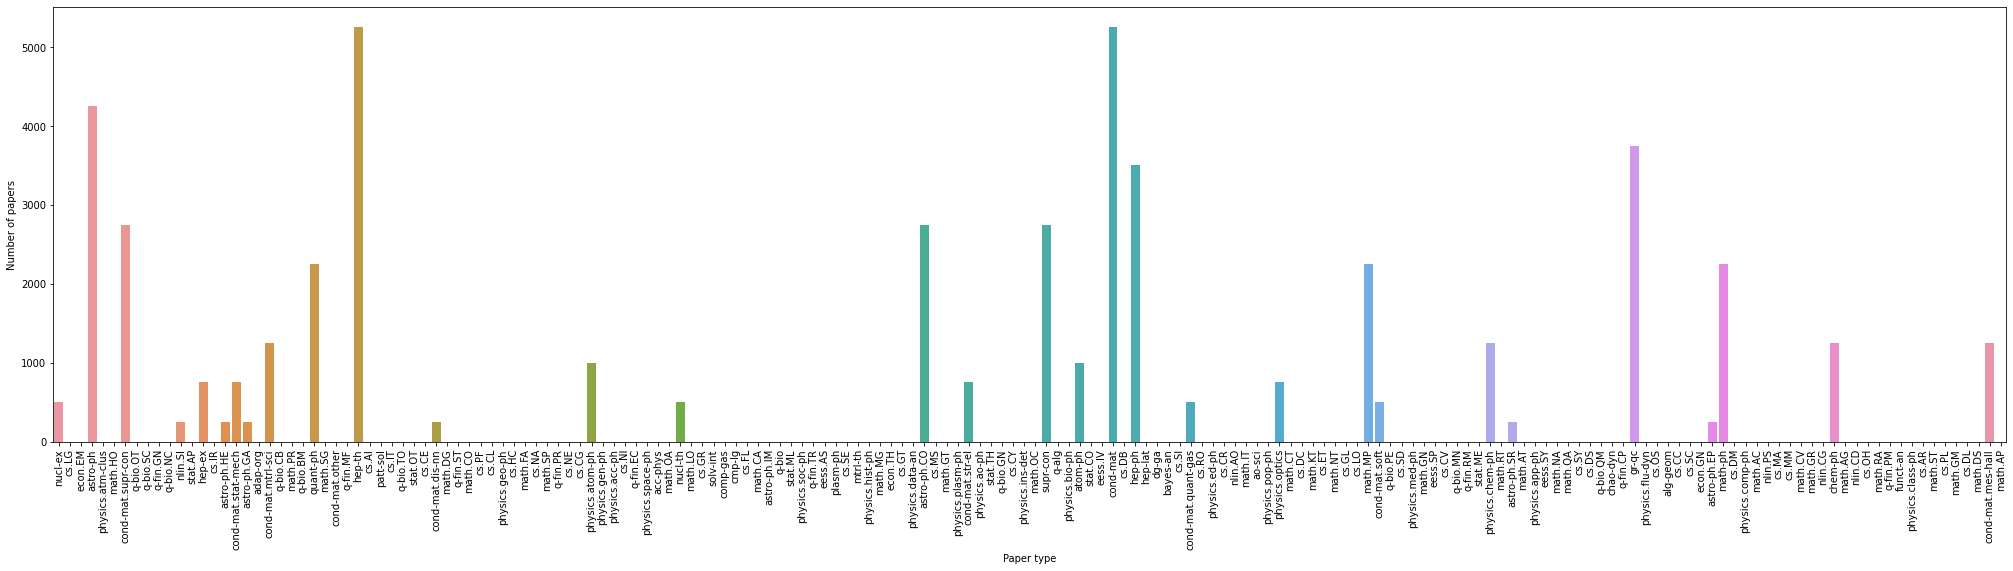

In [ ]:
# no. of samples for each class
categories = arxiv_4_category_count_above_250.columns.to_list()[4:180]
plt.figure(figsize=(35, 8))

ax = sns.barplot(categories, arxiv_4_category_count_above_250.iloc[:, 4:180].sum().values)
plt.ylabel('Number of papers')
plt.xlabel('Paper type')
plt.xticks(rotation=90)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


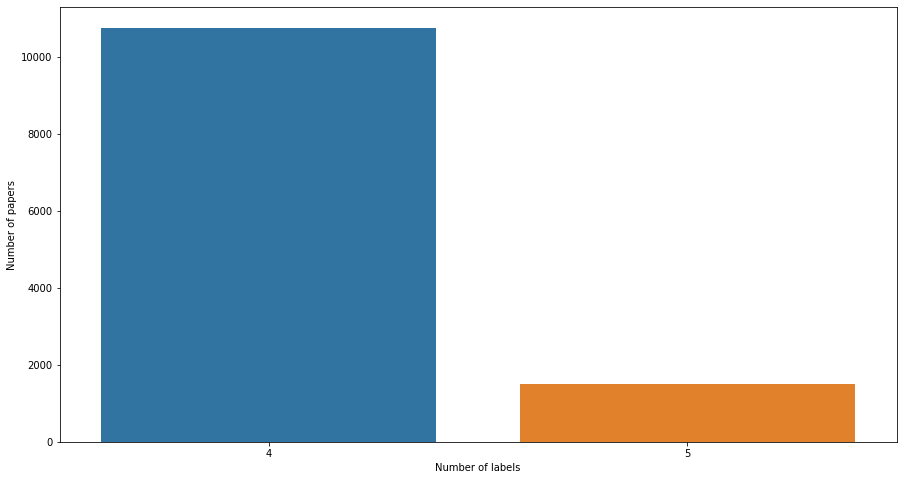

In [ ]:
# no of samples having multiple labels
row_sums = arxiv_4_category_count_above_250.iloc[:, 4:180].sum(axis=1)
multilabel_counts = row_sums.value_counts()

plt.figure(figsize=(15, 8))
ax = sns.barplot(multilabel_counts.index, multilabel_counts.values)
plt.ylabel('Number of papers')
plt.xlabel('Number of labels')
plt.show()

In [ ]:
# save arxiv_data_4_category set as csv
arxiv_4_category_count_above_250.to_csv('arxiv_4_category_count_above_250.csv', index = False)

In [ ]:
########################################################################################

In [ ]:
# Choosing paper categories based on their frequency & eliminating categories with very few papers
shortlisted_categories = arxiv_data_3_category['categories'].value_counts().reset_index(name="count").query("count > 250")["index"].tolist()

In [ ]:
arxiv_3_category_count_above_250 = arxiv_data[arxiv_data["categories"].isin(shortlisted_categories)].reset_index(drop=True)



In [ ]:
# Shuffle DataFrame
arxiv_3_category_count_above_250 = arxiv_3_category_count_above_250.sample(frac=1).reset_index(drop=True)

# Sample roughtly equal number of texts from different paper categories (to reduce class imbalance issues)
arxiv_3_category_count_above_250 = arxiv_3_category_count_above_250.groupby('categories').head(250).reset_index(drop=True)

arxiv_3_category_count_above_250.shape

(59000, 181)

In [ ]:
# save arxiv_data_4_category set as csv
arxiv_3_category_count_above_250.to_csv('arxiv_3_category_count_above_250.csv', index = False)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


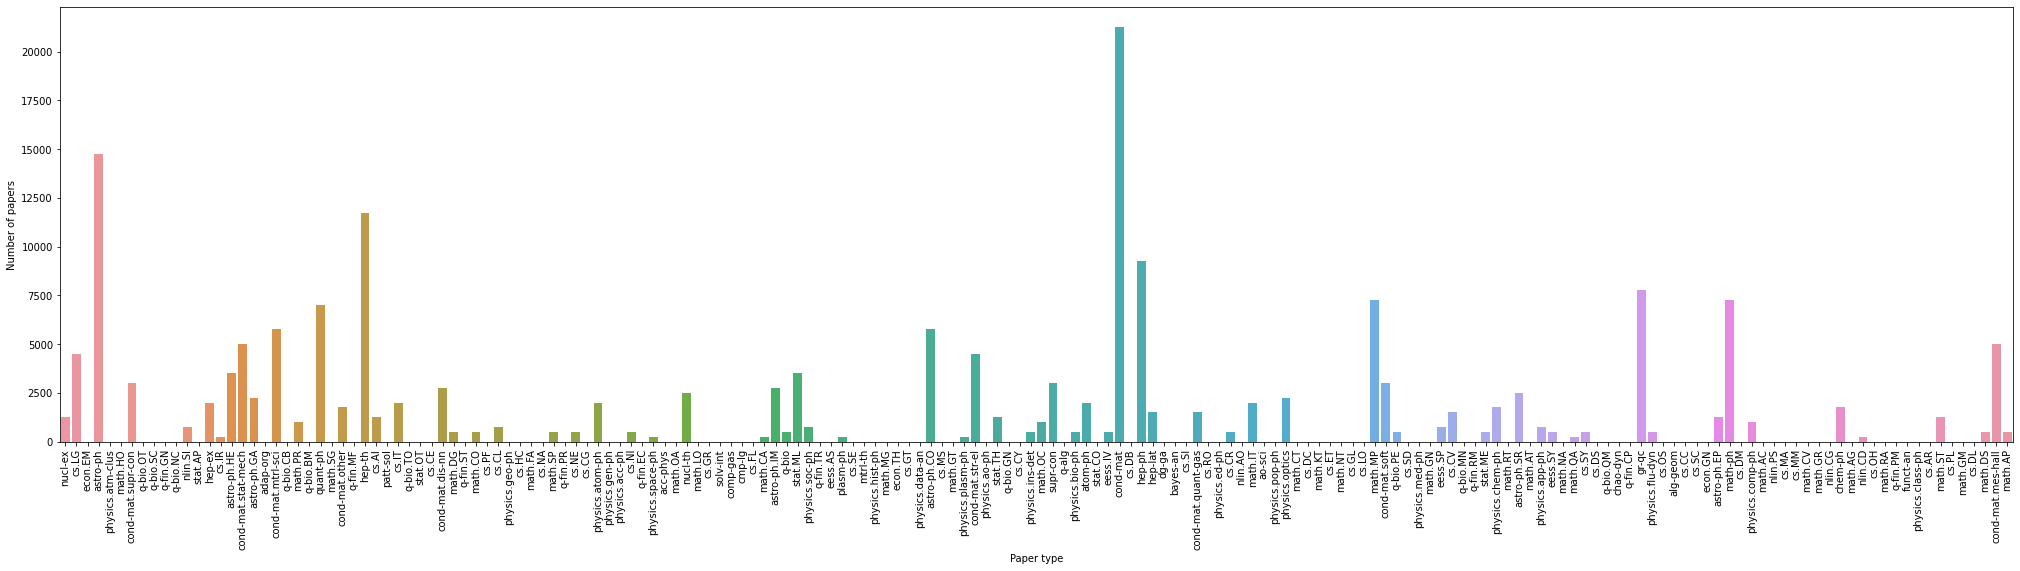

In [ ]:
# no. of samples for each class
categories = arxiv_3_category_count_above_250.columns.to_list()[4:180]
plt.figure(figsize=(35, 8))

ax = sns.barplot(categories, arxiv_3_category_count_above_250.iloc[:, 4:180].sum().values)
plt.ylabel('Number of papers')
plt.xlabel('Paper type')
plt.xticks(rotation=90)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


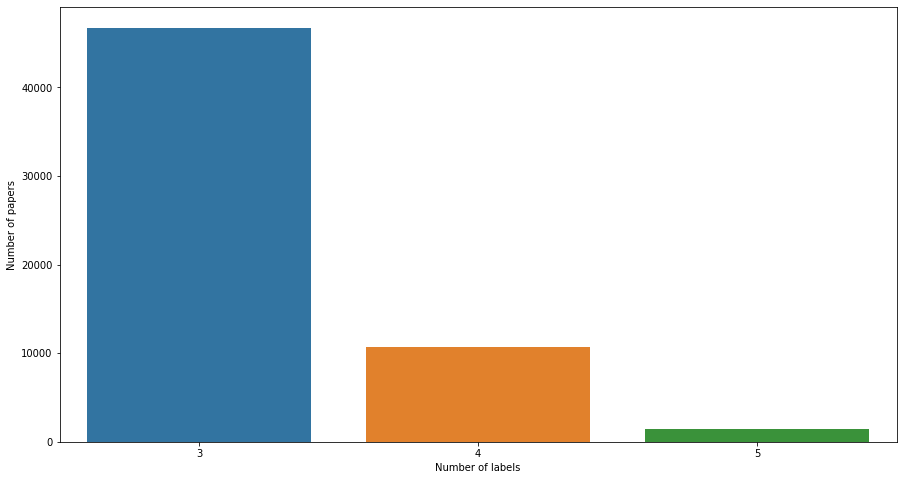

In [ ]:
# no of samples having multiple labels
row_sums = arxiv_3_category_count_above_250.iloc[:, 4:180].sum(axis=1)
multilabel_counts = row_sums.value_counts()

plt.figure(figsize=(15, 8))
ax = sns.barplot(multilabel_counts.index, multilabel_counts.values)
plt.ylabel('Number of papers')
plt.xlabel('Number of labels')
plt.show()

In [ ]:
# data 2 category 

In [6]:
arxiv_data = pd.read_csv('/content/drive/My Drive/Research/Arxiv/arxiv_data_2_category_processed.csv')
arxiv_data.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(1014338, 180)

In [7]:
arxiv_data.head(2)

,category_count,text,id,categories,nucl-ex,cs.LG,econ.EM,astro-ph,physics.atm-clus,math.HO,...,funct-an,physics.class-ph,cs.AR,math.ST,cs.PL,math.GM,cs.DL,math.DS,cond-mat.mes-hall,math.AP
0,2,Sparsity-certifying Graph Decompositions. We...,704.0002,math.CO cs.CG,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,704.0005,math.CA math.FA,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
category_count = arxiv_data[arxiv_data.columns[4:180].to_list()].sum()
print(category_count)

nucl-ex               14074
cs.LG                 63592
econ.EM                 938
astro-ph             191149
physics.atm-clus       1750
                      ...  
math.GM                 439
cs.DL                  2048
math.DS               16086
cond-mat.mes-hall     70243
math.AP               18952
Length: 176, dtype: int64


In [11]:
category_count.describe()

count       176.000000
mean      15371.886364
std       29938.101081
min          16.000000
25%        2075.000000
50%        6768.500000
75%       14962.000000
max      286908.000000
dtype: float64

In [12]:
# Shuffle DataFrame
arxiv_data = arxiv_data.sample(frac=1).reset_index(drop=True)

arxiv_data.shape

(1014338, 180)

In [13]:
# determine which categories to preserve and update dataframe
categories = list(category_count[category_count > 5000].index)
# remove columns pertaining to categories to exclude
data = arxiv_data[list(arxiv_data.columns[:4]) + categories]
print('\tfinal df size:', data.shape)

	final df size: (1014338, 104)


In [14]:
category_count_data_sample = data[data.columns[4:104].to_list()].sum()

In [15]:
category_count_data_sample.describe()

count       100.000000
mean      25554.910000
std       36611.569936
min        5066.000000
25%        8150.000000
50%       14119.500000
75%       27736.250000
max      286908.000000
dtype: float64

In [44]:
# Sample roughtly equal number of texts from different paper categories (to reduce class imbalance issues)
data_sample2 = data.groupby('categories').head(20).reset_index(drop=True)
data_sample2.shape

(208109, 104)

In [45]:
category_count_data_sample2 = data_sample2[data_sample2.columns[4:104].to_list()].sum()

In [46]:
category_count_data_sample2.describe()

count      100.000000
mean      6369.770000
std       5562.302782
min       2004.000000
25%       3567.000000
50%       4530.500000
75%       6619.000000
max      44062.000000
dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


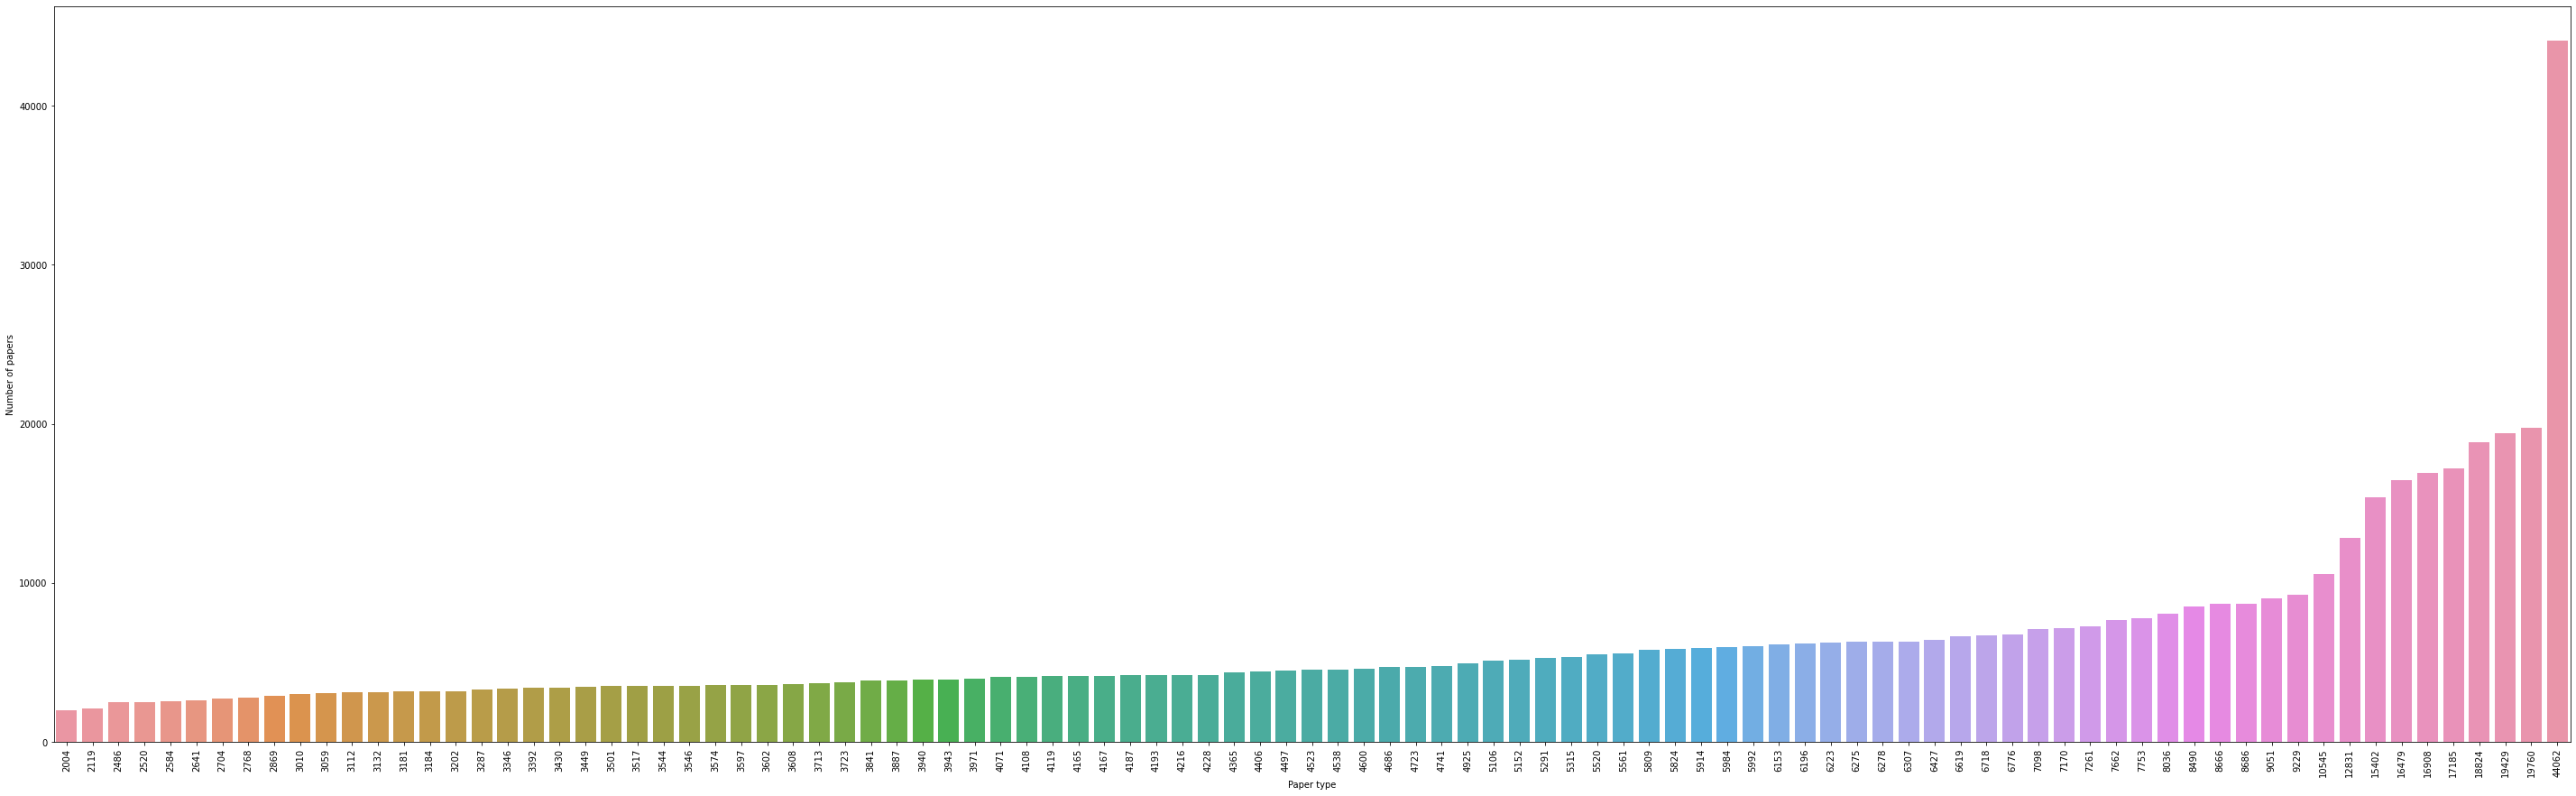

In [47]:
plt.figure(figsize=(50, 15))

ax = sns.barplot(category_count_data_sample2, data_sample2.iloc[:, 4:104].sum().values)
plt.ylabel('Number of papers')
plt.xlabel('Paper type')
plt.xticks(rotation=90)
plt.show()

In [48]:
print(category_count_data_sample2)

nucl-ex               2869
cs.LG                19429
astro-ph             18824
cond-mat.supr-con     3501
q-bio.NC              3202
                     ...  
math.RA               3544
math.ST               4187
math.DS               7753
cond-mat.mes-hall     7662
math.AP               5824
Length: 100, dtype: int64


In [49]:
max(category_count_data_sample2)

44062

In [50]:
# save arxiv_data_2_category sample set as csv
data_sample2.to_csv('arxiv_data_2_category_100_max.csv', index = False)